In [ ]:
#For Python and advanced manipulation import these packages
try:
  import numpy as np
except:
  !pip install numpy
  import numpy as np


try:
  import qiskit
except:
  !pip install qiskit
  import qiskit


try:
  !pip install pylatexenc
  estilo = 'mpl'
  QuantumCircuit(1).draw(estilo)
except:
  estilo = 'text'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 33.2 MB/s 
     |████████████████████████████████| 19.2 MB 98.5 MB/s 
     |████████████████████████████████| 240 kB 61.5 MB/s 
     |████████████████████████████████| 106 kB 55.9 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 943 kB 64.5 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
     |████████████████████████████████| 4.1 MB 69.2 MB/s 
     |████████████████████████████████| 1.9 MB 45.6 MB/s 
     |████████████████████████████████| 112 kB 19.1 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.2-py3-none-any.whl size=12225 sha256=6ec266ac5368448284fdc06325d77e60aaa03f1b961da35072bf09c0bd491365
  Stored in directory: /root/.cache/pip/wheels/30/dc/90/0ee

In [ ]:
#Libraries for quantum circuits
from qiskit import QuantumCircuit, execute

#For calibration
from qiskit import pulse, transpile
from qiskit.pulse.library import Gaussian

#Personalized gates
from qiskit.circuit import Gate
from qiskit import QiskitError

#For information
import qiskit.tools.jupyter

In [ ]:
from qiskit import IBMQ

#Load our IBM Quantum account
provider = IBMQ.enable_account("c8440457d4ccb10786816758f1ffd909ea528ea12c2ac744598dd73ec90d1476ffa9f58251d0db77b256bcb655f85be37e3163e5548178ed618bc2ec2c57fbf4")
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [ ]:
from qiskit.providers.ibmq import least_busy

#This searches for the least busy backend, with 5 qubits
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
least_busy(small_devices)

<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
#Once we saw which backend was lest busy, we choose it with .get_backend() 
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_quito')

In [ ]:
backend_config = backend.configuration()

In [ ]:
#Sampling time of the pulses

dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

Sampling time: 0.2222222222222222 ns


In [ ]:
#Timing constraint of the backend
backend.configuration().timing_constraints

{'acquire_alignment': 16,
 'granularity': 16,
 'min_length': 64,
 'pulse_alignment': 1}

In [ ]:
#We get those values and save it in a variable
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

In [ ]:
lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

Least common multiple of acquire_alignment and pulse_alignment: 16


In [ ]:
backend_defaults = backend.defaults()

In [ ]:
#Finding qubit's frequency

#Defining units
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

#We will work with the following qubit
qubit = 0

#Center the sweep in a qubit estimated frequency 
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # in Hz
                                                    
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data ???
scale_factor = 1e-7

#Sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
#With 1MHz steps
frequency_step_Hz = 1 * MHz

#Sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

#Array of the frequencies 
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 5.30042770596024 GHz.
The sweep will go from 5.280427705960239 GHz to 5.320427705960239 GHz in steps of 1.0 MHz.


In [ ]:
#This function returns the closest multiple between two values
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

In [ ]:
#Lenght of the pulse: it has to be multiple of 16 (granularity)
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

In [ ]:
#Lenght of the delay, converts s to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

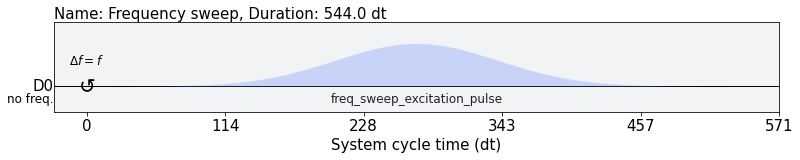

In [ ]:
from qiskit.circuit import Parameter      
from qiskit.circuit import QuantumCircuit, Gate

#Drive pulse parameters (us = microseconds)
#Determines width of the Gaussian
drive_sigma_sec = 0.015 * us   

#Truncating parameter               
drive_duration_sec = drive_sigma_sec * 8               

#Pulse's amplitude                   
drive_amp = 0.05

#Base schedule
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    #seconds_to_samples(s) gets the number of samples that will elapse in seconds on the active backend.
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    #Returns the qubit's DriveChannel on the active backend
    #Drive channels transmit signals to qubits which enact gate operations
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    #Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

#Plot Gaussian pulse    
sweep_sched.draw() 

In [ ]:
#Gate(name, num_qubits, params) creates a new gate 
sweep_gate = Gate("sweep", 1, [freq])

#Create the quantum circuit, 1 qubit, 1 bit
qc_sweep = QuantumCircuit(1, 1)

#Add our new gate sweep_gate to the quantum circuit
qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)

"""This command: add_calibration(gate, qubits, schedule, params=None) 
registers a low-level, custom pulse definition for the given gate"""
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

#Frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz #convert to Hz

"""This command: assign_parameters(parameters, inplace=False)
assigns parameters to new parameters or values"""
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

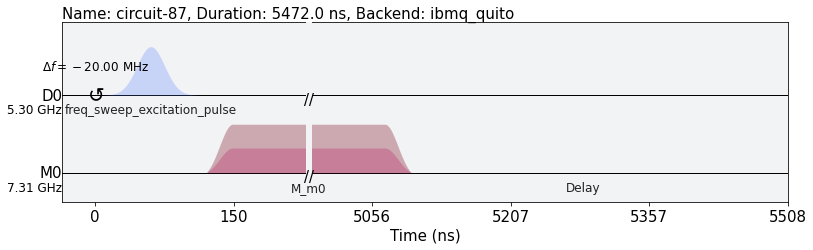

In [ ]:
from qiskit import schedule

#schedule(circuits, backend) to schedule a circuit to a pulse Schedule, using the backend
sweep_schedule = schedule(exp_sweep_circs[0], backend)
#To show the schedule 
sweep_schedule.draw(backend=backend)

In [ ]:
#Each schedule will be repeated num_shots_per_frequency times
num_shots_per_frequency = 1024

job = backend.run(exp_sweep_circs, 
                  meas_level=1, #kerneled data
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

In [ ]:
from qiskit.tools.monitor import job_monitor

#Monitor the job status
job_monitor(job)

Job Status: job has successfully run


In [ ]:
#Retrieve the results
frequency_sweep_results = job.result(timeout=1200)

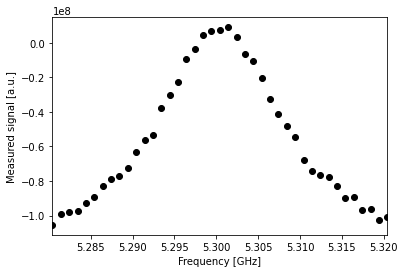

In [ ]:
#Plotting the results with matplotlib

import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    #Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    #Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

#Plot frequencies vs. real part of sweep values
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') 
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [ ]:
#Using scipy for the curve fitting

from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit


In [ ]:
#Fitting the curve. We use a Lorentzian function for the fit

"""We need to assign the correct initial parameters for our data
A is related to the height of the curve,
B is related to the width of the Lorentzian,
C is the cut with the Y axis and
q_freq is the estimated peak frequency of the curve."""

fit_params, y_fit = fit_function(frequencies_GHz,
                                np.real(sweep_values), 
                                lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                [1e8, 5.3, 0.02, -1e8] # initial parameters for curve_fit
                               )

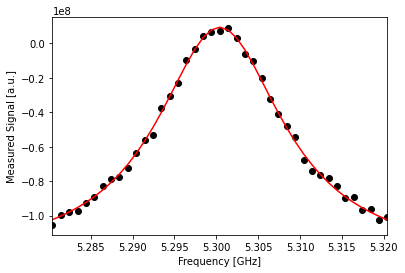

In [ ]:
#Plotting the data
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
#and plotting the fit
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [ ]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 5.30043 GHz to 5.30041 GHz.


In [ ]:
#Calibrating using a pi pulse
#Pi pulses takes a qubit from |0> to |1> (X gate) 

# Rabi experiment parameters
num_rabi_points = 50

#Drive amplitude values to iterate over
#50 amplitudes evenly spaced from 0 to 0.75 using linspace
drive_amp_min = 0
drive_amp_max = 0.55 #Changed this parameter
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [ ]:
#Build the Rabi experiments:
"""A drive pulse at the qubit frequency, followed by a measurement,
where we vary the drive amplitude each time"""

#This is similar to the frequency sweep schedule
drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [ ]:
#New rabi gate
rabi_gate = Gate("rabi", 1, [drive_amp])

#New quantum circuit for Rabi Experiment
qc_rabi = QuantumCircuit(1, 1)

#Add the rabi_gate we just defined
qc_rabi.append(rabi_gate, [0])
#Measure the QC 
qc_rabi.measure(0, 0)
#Add calibration to the rabi_gate
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

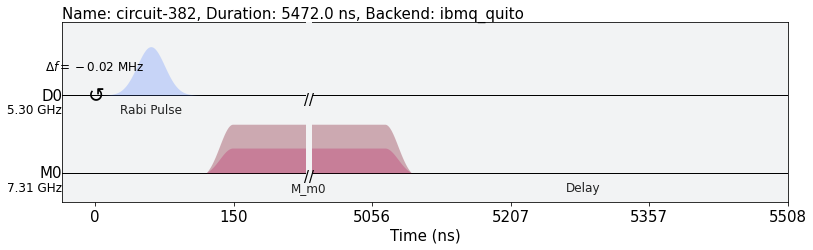

In [ ]:
#Create our schedule and draw it

rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [77]:
num_shots_per_point = 1024

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [78]:
#Get the results
rabi_results = job.result(timeout=120)

In [79]:
#We need to extract the results and fit them to a sinusoidal curve.
"""The range of amplitudes we got will rotate (hopefully) the qubit several times 
around the Bloch sphere. We need to find the drive amplitude needed for the
signal to oscillate from a maximum to a minimum (all |0> to all |1>).
That's exactly what gives us the calibrated amplitude represented 
by the pi pulse"""

#First we center the data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

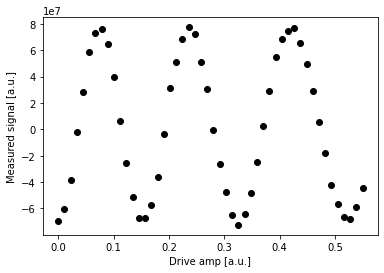

In [80]:
#Empty array for Rabi values
rabi_values = []

#Remember we defined num_rabi_points initially at 50
for i in range(num_rabi_points):
    #Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

#We get the real values from the centered rabi_values
rabi_values = np.real(baseline_remove(rabi_values))

#Plot the results
plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
#Plotting amplitudes vs Rabi values
plt.scatter(drive_amps, rabi_values, color='black') 
plt.show()

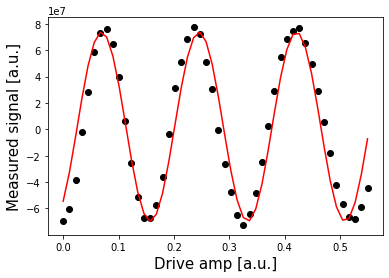

In [152]:
#Now we fit the curve, similarly to the frequencies fit

fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [7e7, 0, 0.20, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] #get period of rabi oscillation

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()


In [87]:
#Pi pulse's amplitude needed for the signal to oscillate from maximum to minimum
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.08803424077209276


In [88]:
#We can define our pi pulse now

with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

In [89]:
#Now we create a ground state to try our pi pulse
qc_gnd = QuantumCircuit(1, 1)
qc_gnd.measure(0, 0)

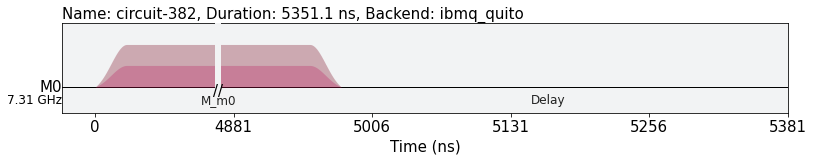

In [90]:
#And its ground schedule
gnd_schedule = schedule(qc_gnd, backend)
gnd_schedule.draw(backend=backend)

In [91]:
#We create the excited state 
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)

In [92]:
#And another QC for the excited state
qc_exc = QuantumCircuit(1, 1)
#Apply X gate to qubit 0 
qc_exc.x(0)
#And measure it
qc_exc.measure(0, 0)

#Then we add the calibration from the excited state's sched
qc_exc.add_calibration("x", (0,), exc_schedule, [])

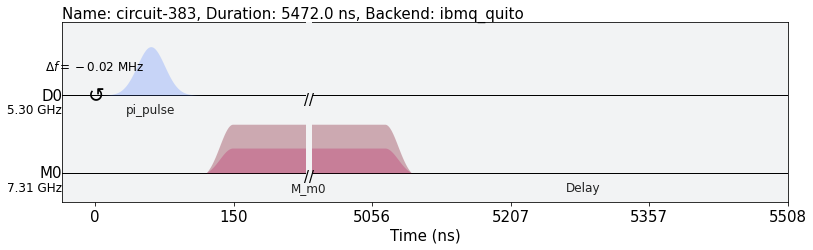

In [93]:
#Now execute the exc state's schedule
exec_schedule = schedule(qc_exc, backend)
exec_schedule.draw(backend=backend)

In [94]:
#Preparation schedules for the ground and excited states
num_shots = 1024

job = backend.run([qc_gnd, qc_exc], 
                  #Choosing meas_level 1 for kerneled data
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

In [95]:
job_monitor(job)

Job Status: job has successfully run


In [96]:
gnd_exc_results = job.result(timeout=120)

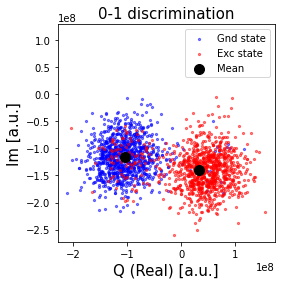

In [97]:
#Getting the ground and excited state's results
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

#Plotting results
plt.figure()

#Ground state in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='Gnd state')
#Excited state in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='Exc state')

plt.axis('square')

#Plot a large black dot for the average result of the 0 and 1 states
#Mean of real and imaginary parts of results
mean_gnd = np.mean(gnd_results)
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=100, cmap='viridis', c='black',alpha=1.0, label='Mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=100, cmap='viridis', c='black',alpha=1.0)

plt.ylabel('Im [a.u.]', fontsize=15)
plt.xlabel('Q (Real) [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)
plt.legend()

plt.show()

In [98]:
"""Setting up a classifier function:
returns 0 if a given point is closer to the mean of ground state results
and returns 1 if the point is closer to the avg exc state results"""

import math

#This functions classifies the given state as |0> or |1>.
def classify(point: complex):
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))


In [99]:
#T1 time: time it takes for a qubit to decay from exc_state to gnd_state
"""To measure T1 we use the pi pulse we've calibrated, then a measure pulse.
But first we have to insert a delay."""

#T1 experiment parameters
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

In [100]:
#We define the delay
delay = Parameter('delay')
#Create another quantum circuit
qc_t1 = QuantumCircuit(1, 1)

#X Gate 
qc_t1.x(0)
#Delay
qc_t1.delay(delay, 0)
#Measurement
qc_t1.measure(0, 0)
#Calibration on X gate with our pi pulse
qc_t1.add_calibration("x", (0,), pi_pulse)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

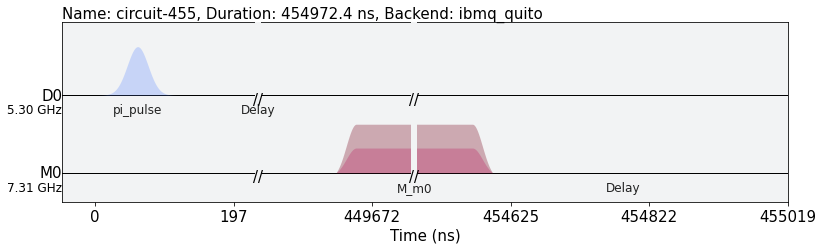

In [101]:
#Schedule for T1
sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [102]:
#Execution settings
num_shots = 256

job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

In [103]:
job_monitor(job)

Job Status: job has successfully run


In [104]:
t1_results = job.result(timeout=120)

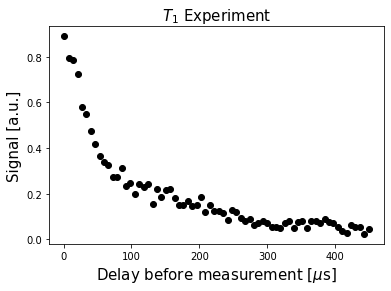

In [105]:
#Getting the results to plot

t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    #sum() returns the sum of all items.
    #map() returns a map object of the result after applying a given
    #function (sum) to each item of a given iterable.
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

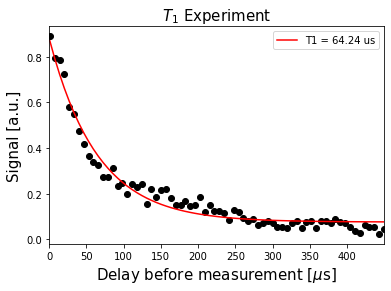

In [106]:
#Fitting data with an exponential curve
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

In [107]:
#Measure qubit frequency (precisely) with Ramsey Experiment
#Apply a pi/2 pulse, wait some time, and then anothe pi/2 pulse.

#Ramsey experiment parameters
time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

#Drive parameters
#Drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

#Build the x_90 pulse, which is an X rotation of 90 degrees, a pi/2 rotation
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [108]:
#Now we have to drive the pulses off-resonance an amount detuning_MHz
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) #Ramsey freq in Hz

In [109]:
#Pulse for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [110]:
#Ramsey gate
ramsey_gate = Gate("ramsey", 1, [delay])

#Another QC for Ramsey experiment
qc_ramsey = QuantumCircuit(1, 1)

#Adding the gate to the circuit
qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

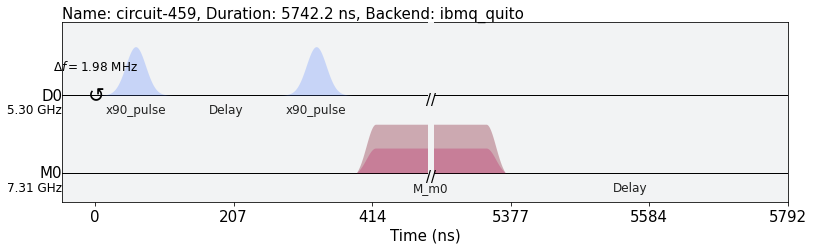

In [111]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [112]:
#Execution settings for Ramsey experimet
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

In [113]:
job_monitor(job)

Job Status: job has successfully run


In [114]:
ramsey_results = job.result(timeout=120)

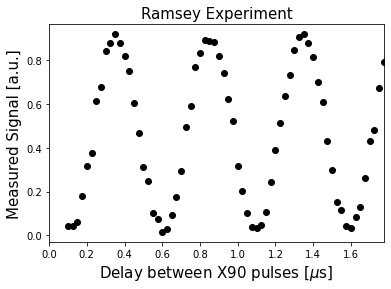

In [115]:
#Array for the results
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
#Plotting the results
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

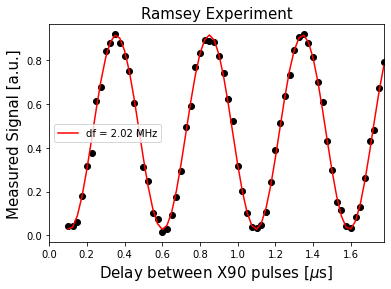

In [120]:
#Fitting data to a sinusoid

fit_params, y_fit = fit_function(delay_times_sec/us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 2.2, 0, 0.4] 
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times_sec/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [121]:
precise_qubit_freq = rough_qubit_frequency + (detuning_MHz - del_f_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")

Our updated qubit frequency is now 5.30039 GHz. It used to be 5.300411 GHz


In [122]:
#Measuring coherence time (T2) with Hahn Echoes experiment
#It's the same as Ramsey's experiment, with a pi pulse between the pi/2

#T2 experiment parameters
tau_max_sec = 200 * us
tau_step_sec = 4 * us
delay_times_sec = np.arange(2 * us, tau_max_sec, tau_step_sec)

In [123]:
#Define the delay and build the pulse for T2
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2 delay Experiment") as t2_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(pi_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [124]:
#Define T2 gate
t2_gate = Gate("t2", 1, [delay])

#QC for T2
qc_t2 = QuantumCircuit(1, 1)

#Add T2 gate
qc_t2.append(t2_gate, [0])
qc_t2.measure(0, 0)
#Add calibration with delay
qc_t2.add_calibration(t2_gate, (0,), t2_schedule, [delay])

exp_t2_circs = [qc_t2.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

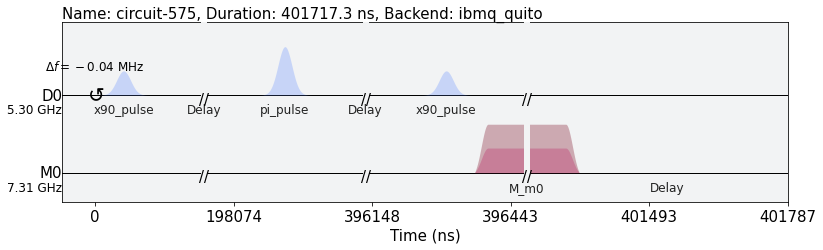

In [125]:
#Schedule for T2 and show it
t2_schedule = schedule(exp_t2_circs[-1], backend)
t2_schedule.draw(backend=backend)

In [126]:
#Execution settings
num_shots_per_point = 512

job = backend.run(exp_t2_circs,
                  meas_level=1, #Kerneled data
                  meas_return='single',
                  shots=num_shots_per_point)

In [127]:
job_monitor(job)

Job Status: job has successfully run


In [128]:
#Getting results
t2_results = job.result(timeout=120)

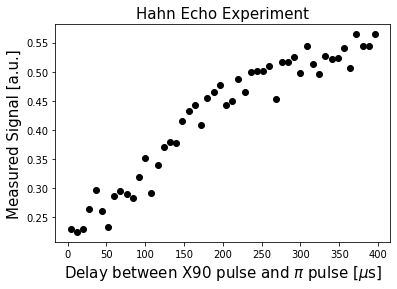

In [129]:
#T2 empty array
t2_values = []

#Retrieving results and adding them classified to the array
for i in range(len(delay_times_sec)):
    iq_data = t2_results.get_memory(i)[:,qubit] * scale_factor
    t2_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

#Plot ressults for Hanh Echo experiment
plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

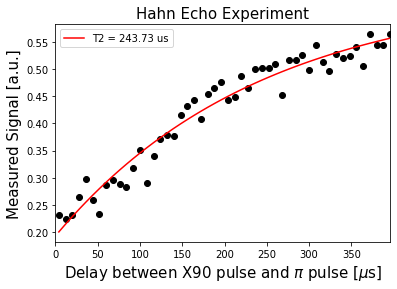

In [130]:
#Fitting data with an exponential function
fit_params, y_fit = fit_function(2*delay_times_sec/us, t2_values,
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params

#Plotting results and fit curve
plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.plot(2*delay_times_sec/us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*delay_times_sec/us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

In [131]:
#Dynamical decoupling technique
#Used to extract longer coherence times from qubits

#Experiment parameters
tau_sec_min = 1 * us
tau_sec_max = 180 * us
tau_step_sec = 4 * us
taus_sec = np.arange(tau_sec_min, tau_sec_max, tau_step_sec)

num_sequence = 1 
print(f"Total time ranges from {2.*num_sequence*taus_sec[0] / us} to {2.*num_sequence*taus_sec[-1] / us} us")

Total time ranges from 2.0 to 354.0 us


In [132]:
#This schedule is different from the others...
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2DD delay Experiment") as T2DD_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay/2, drive_chan)
    for loop_counts in range(num_sequence):
        pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
            pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
            pulse.call(pi_pulse)
        if loop_counts != num_sequence-1:
            pulse.delay(delay, drive_chan)
    pulse.delay(delay/2, drive_chan)
    pulse.call(x90_pulse)

In [133]:
#Create new gate for T2 Dynamical Decouling 
T2DD_gate = Gate("T2DD", 1, [delay])
#Another QC
qc_T2DD = QuantumCircuit(1, 1)

qc_T2DD.append(T2DD_gate, [0])
qc_T2DD.measure(0, 0)
qc_T2DD.add_calibration(T2DD_gate, (0,), T2DD_schedule, [delay])

exp_T2DD_circs = [qc_T2DD.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in taus_sec]

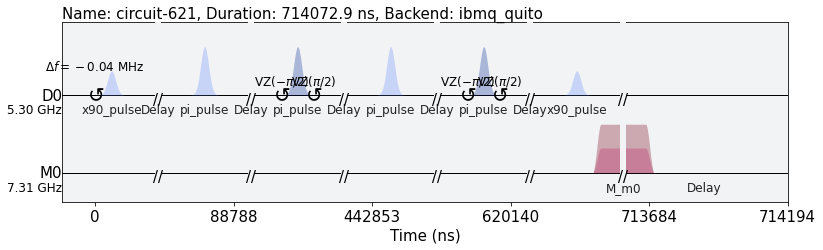

In [134]:
#Schedule fot T2 D.D.
T2DD_schedule = schedule(exp_T2DD_circs[-1], backend)
T2DD_schedule.draw(backend=backend)

In [135]:
num_shots_per_point = 1024

job = backend.run(exp_T2DD_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)

In [136]:
job_monitor(job)

Job Status: job has successfully run


In [137]:
T2DD_results = job.result(timeout=120)

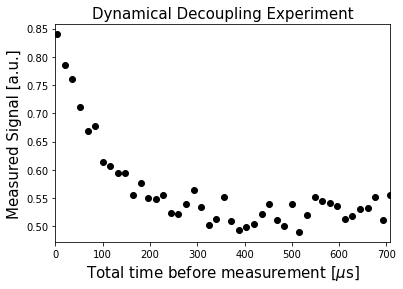

In [138]:
times_sec = 4*num_sequence*taus_sec
DD_values = []

for i in range(len(times_sec)):
    iq_data = T2DD_results.get_memory(i)[:,qubit] * scale_factor
    DD_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(times_sec/us, DD_values, color='black')
plt.xlim(0, np.max(times_sec/us))
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.show()

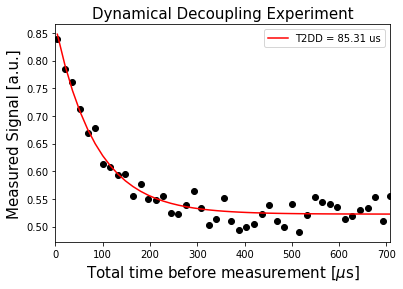

In [139]:
# Fit the data
fit_func = lambda x, A, B, T2DD: (A * np.exp(-x / T2DD) + B)
fitparams, conv = curve_fit(fit_func, times_sec/us, DD_values, [3.5, 0.8, 150])

_, _, T2DD = fitparams
plt.scatter(times_sec/us, DD_values, color='black')
plt.plot(times_sec/us, fit_func(times_sec/us, *fitparams), color='red', label=f"T2DD = {T2DD:.2f} us")
plt.xlim([0, np.max(times_sec/us)])
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.legend()
plt.show()